In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [26]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    #df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year

    df['sin_hour'] = np.sin(2*np.pi * df[time_column].dt.hour/24.)
    df['cos_hour'] = np.cos(2*np.pi * df[time_column].dt.hour/24.)
    
    return df

In [27]:
def add_interactions(df): 
    df['sun_elev_cloud_cover_interaction'] = df['sun_elevation:d'] * df['total_cloud_cover:p']

    df['radiation_interaction'] = df['clear_sky_rad:W'] * df['diffuse_rad:W'] * df['direct_rad:W']

    df['atmospheric_interaction'] = df['air_density_2m:kgm3'] * df['msl_pressure:hPa']

    df['temp_humidity_interaction'] = df['dew_point_2m:K'] * df['t_1000hPa:K']

    df['snow_radiation_interaction'] = df['fresh_snow_1h:cm'] * df['clear_sky_rad:W']  # Replace 'clear_sky_rad:W' with 'albedo' if available

    return df

In [28]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

def add_polynomial_features(df, feature_list, degree=2):
    """
    Adds polynomial features for specified features in a DataFrame.

    Parameters:
    - df: pandas.DataFrame - The original DataFrame.
    - feature_list: list - A list of column names to create polynomial features for.
    - degree: int - The degree of the polynomial features to create.

    Returns:
    - df: pandas.DataFrame - The DataFrame with added polynomial features.
    """

    # Initialize the PolynomialFeatures transformer
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)

    for feature in feature_list:
        # Check if the feature exists in the dataframe to avoid KeyError
        if feature in df.columns:
            # Reshape the feature column to a 2D array for PolynomialFeatures
            feature_data = df[[feature]].values
            
            # Create polynomial features for the selected feature
            feature_poly = poly_transformer.fit_transform(feature_data)
            
            # Generate new feature names
            feature_names = [f"{feature}^{i}" for i in range(1, degree + 1)]
            
            # Convert the output array to a DataFrame with new feature names
            feature_poly_df = pd.DataFrame(feature_poly, columns=feature_names)
            
            # Concatenate the new polynomial features to the original DataFrame
            df = pd.concat([df, feature_poly_df.iloc[:, 1:]], axis=1)  # Skip the original feature column
            
    return df

def add_rolling_average(df, window_size, fill_method='ffill'):
    """
    Adds rolling average columns to the dataframe based on the specified window size.
    Args:
    - df: The input dataframe.
    - window_size: The number of periods to consider for calculating the rolling average.
    
    Returns:
    - df with new columns for the rolling averages of selected features.
    """
    rolling_features = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
    for feature in rolling_features:
        rolling_name = f'{feature}_rolling_avg_{window_size}'
        df[rolling_name] = df[feature].rolling(window=window_size, min_periods=1, center=True).mean()

        # Handle NaN values at the edges
        if fill_method == 'ffill':
            df[rolling_name].fillna(method='ffill', inplace=True)
        elif fill_method == 'bfill':
            df[rolling_name].fillna(method='bfill', inplace=True)
    return df

In [29]:

def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [30]:
def make_categorical(df, feature_list):
    for feature in feature_list:
        df[feature] = df[feature].astype('category')
    return df

In [31]:
def add_time_delta(observed, estimated, test):
    estimated['time_delta'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    observed['time_delta'] = 0
    test['time_delta'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    return observed, estimated, test

def add_is_estimated(observed, estimated, test):
    estimated['is_estimated'] = 1
    observed['is_estimated'] = 0
    test['is_estimated'] = 1
    return observed, estimated, test

def process_data(observed, estimated, test):
    observed, estimated, test = add_time_delta(observed, estimated, test)
    observed, estimated, test = add_is_estimated(observed, estimated, test)
    train = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
    return train, test

def set_date_time(targets, observed, estimated, test):
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])
    return targets, observed, estimated, test

def resample_data(observed, estimated, test):
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    return observed_resampled, estimated_resampled, test_resampled

def extract_is_day_feature(test):
    is_day_feature = test[['date_forecast', 'is_day:idx']]
    is_day_feature['is_day:idx'] = is_day_feature['is_day:idx'].replace({0.25: 1, 0.5: 1, 0.75: 1, 1: 1, 0: 0})
    return is_day_feature

def extract_time_limit(targets):
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    return first_date, last_date

def drop_features(train, test):
    train = train.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    test = test.drop(columns=['date_forecast'])
    return train, test

def add_several_rolling_average(train, test, lst_of_window_sizes):
    for size in lst_of_window_sizes: 
        train = add_rolling_average(train, window_size=size)
        test = add_rolling_average(test, window_size=size)
    return train, test

In [32]:
def calculate_incidence_angles(df, latitude = 60):
    # Define a function to calculate the angle of incidence for a given row
    def angle_of_incidence(row, tilt_angle_rad, panel_azimuth_rad):
        sun_elevation_rad = np.radians(row['sun_elevation:d'])
        sun_azimuth_rad = np.radians(row['sun_azimuth:d'])
        cos_theta = (
            np.sin(sun_elevation_rad) * np.sin(tilt_angle_rad) +
            np.cos(sun_elevation_rad) * np.cos(tilt_angle_rad) * np.cos(sun_azimuth_rad - panel_azimuth_rad)
        )
        cos_theta = np.clip(cos_theta, -1, 1)  # Ensure cos_theta is within valid range
        return np.degrees(np.arccos(cos_theta))
    
    # Calculate the tilt angle and panel azimuth assuming Norway is in the northern hemisphere
    tilt_angle_rad = np.radians(latitude)
    panel_azimuth_rad = 0  # True south

    # Apply the angle_of_incidence function to each row
    df['angle_of_incidence'] = df.apply(angle_of_incidence, axis=1, tilt_angle_rad=tilt_angle_rad, panel_azimuth_rad=panel_azimuth_rad)
    
    return df

In [33]:
def add_wind_features(train, test):
    for df in [train, test]:
        # Horizontal wind speed magnitude at 10 meters
        df['wind_speed_10m_vector_magnitude:ms'] = np.sqrt(df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)

        # Wind direction at 10 meters
        df['wind_direction_10m:degrees'] = np.degrees(np.arctan2(df['wind_speed_v_10m:ms'], df['wind_speed_u_10m:ms']))

        # Temperature-adjusted wind speed at 10 meters
        df['temp_adjusted_wind_speed_10m:ms'] = df['wind_speed_10m:ms'] * (df['t_1000hPa:K'] / 273.15)

        # Vertical wind shear between surface and 1000 hPa
        # Note: this requires careful interpretation as mentioned earlier
        df['wind_shear_1000hPa_10m:ms'] = df['wind_speed_w_1000hPa:ms'] - df['wind_speed_10m:ms']

        # Wind energy density at 10 meters
        df['wind_energy_density_10m:Wm2'] = 0.5 * 1.225 * (df['wind_speed_10m:ms']**3)  # Using 1.225 kg/m3 as air density at sea level

    return train, test

In [34]:
def remove_constant_blocks(df):
    '''
    Remove constant blocks from the dataframe, i.e. where the value in pv_measurement is constant
    Ex: 0,0,1 -> 0,1
    '''
    df['diff'] = df['pv_measurement'].diff().fillna(0)
    df['constant'] = (df['diff'] == 0).astype(int)
    df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block

    # Keep the first occurrence by ensuring the block size is greater than 1 and that it's a constant value.
    df = df[~((df['block_size'] >= 1) & (df['pv_measurement'] != 0))]

    # Drop the helper columns
    df.drop(['diff', 'constant', 'block', 'block_size'], axis=1, inplace=True)
    
    return df

# def remove_nonzero_constant_blocks(df, column='pv_measurement'):
#     '''
#     Remove constant blocks from the dataframe where the value in the specified column is constant and non-zero.
#     Ex: 0,0,1,1,1 -> 0,0
#         2,2,0,0,1 -> 0,0,1
#     '''
#     # Calculate the difference between consecutive rows and identify constant blocks
#     df['diff'] = df[column].diff().fillna(0)
#     df['constant'] = (df['diff'] == 0).astype(int)
#     df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    
#     # Determine the value of each block and its size
#     df['block_value'] = df.groupby('block')[column].transform('first') # The value of the block
#     df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block
    
#     # We only want to keep the block if its size is 1 (non-constant) or if the constant value is 0
#     # This is done by checking if the block size is 1 or if the block value is 0.
#     df = df[(df['block_size'] == 1) | (df['block_value'] == 0)]
    
#     # Drop the helper columns
#     df.drop(['diff', 'constant', 'block', 'block_value', 'block_size'], axis=1, inplace=True)
    
#     return df

In [35]:
def preprocessing(targets, observed, estimated, test):
    targets, observed, estimated, test = set_date_time(targets, observed, estimated, test)
    
    observed, estimated, test = resample_data(observed, estimated, test)

    is_day_feature = extract_is_day_feature(test)

    first_date, last_date = extract_time_limit(targets)
    start_date, end_date = '2017-07-01', '2024-08-30'  
   
    
    train, test = process_data(observed, estimated, test)

    train, test = add_several_rolling_average(train, test, lst_of_window_sizes = [3, 5, 7])

    merged_data = pd.merge(targets, train, how='inner', left_on='time', right_on='date_forecast')

    # Remove constant blocks from the data
    train = remove_constant_blocks(merged_data)

    ###### This one should be double checked ########
    # Remove rows where pv_measurement is 0
    train = train[merged_data['pv_measurement'] != 0]

    # Add the time-based features
    train = add_time_features(train, 'time')  
    test = add_time_features(test, 'date_forecast') 

    targets = train[['time', 'pv_measurement']]
    
    plot_targets(targets, start_date, end_date)

    train, test = drop_features(train, test)

    # train = calculate_incidence_angles(train)
    # test = calculate_incidence_angles(test)

    # train, test = add_wind_features(train, test)

    return train, test, is_day_feature, targets

In [36]:
from pycaret.regression import *
def process_location_catboost(exp_reg):
    
    catboost = exp_reg.create_model('catboost')
    #catboost = exp_reg.tune_model(catboost)
    #catboost = exp_reg.ensemble_model(catboost, method='Bagging')

    return catboost

def process_location_lightgbm(exp_reg):

    lightgbm = exp_reg.create_model('lightgbm')
    #lightgbm = exp_reg.tune_model(lightgbm)
    #lightgbm = exp_reg.ensemble_model(lightgbm, method='Bagging')

    return lightgbm


# Run

In [37]:
# loc = "C"
# train = pd.read_parquet(f'Data/{loc}/train_targets.parquet').fillna(0)
# X_train_estimated = pd.read_parquet(f'Data/{loc}/X_train_estimated.parquet')
# X_train_observed = pd.read_parquet(f'Data/{loc}/X_train_observed.parquet')
# X_test_estimated = pd.read_parquet(f'Data/{loc}/X_test_estimated.parquet')

# #lage dag og måned feature der man aggregerer opp 
# # Preprocess data
# X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
# y_train = targets
# if X_train.empty or len(y_train) == 0:
#     print(f"X_train or y_train is empty for location {loc}")

# # Ensure X and y have the same length
# print(len(X_train), 'X')
# print(len(y_train),'y')
# min_length = min(len(X_train), len(y_train))
# X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]


# data = X_train.copy()
# data.columns = data.columns.str.replace('[^\w\s]', '')

# X_test.columns = X_test.columns.str.replace('[^\w\s]', '')

# data['target'] = y_train['pv_measurement']

# exp_reg = RegressionExperiment()
# exp_reg.setup(
#     data=data,
#     # train_size=trainsize,
#     target='target', 
#     session_id=123,
#     categorical_features=['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated'],
#     # html=False,
#     experiment_name=f'exp_{loc}', 
#     use_gpu=True,
#     # verbose=False
# )

# # Process the location data and get the final model
# model_catboost = exp_reg.create_model('catboost',
# #   random_state=123
# )
# print("#############################################")
# print("Catboost Done")
# model_lightgbm = exp_reg.create_model('lightgbm',
# #   random_state=123
# )
# model_catboost_feature_importance = pd.DataFrame(model_catboost.feature_importances_, index=model_catboost.feature_names_, columns = ["Importance"])
# model_catboost_feature_importance.sort_values(by="Importance", ascending=False, inplace=True)
# model_catboost_feature_not_importance_names = model_catboost_feature_importance[model_catboost_feature_importance["Importance"] < .5].index.tolist()
# print(f"Cat: {len(model_catboost_feature_not_importance_names)}")

# model_lightgbm_feature_importance = pd.DataFrame(model_lightgbm.feature_importances_, index=model_lightgbm.feature_name_, columns = ["Importance"])
# model_lightgbm_feature_importance.sort_values(by="Importance", ascending=False, inplace=True)
# model_lightgbm_feature_not_importance_names = model_lightgbm_feature_importance[model_lightgbm_feature_importance["Importance"] < .5].index.tolist()
# print(f"LGBM: {len(model_lightgbm_feature_not_importance_names)}")
# print(list(set(model_catboost_feature_not_importance_names) & set(model_lightgbm_feature_not_importance_names)))

In [38]:
# print(list(set(model_catboost_feature_not_importance_names) & set(model_lightgbm_feature_not_importance_names)))


In [39]:
remove_features_A = ['dew_or_rimeidx_-0.25', 'is_in_shadowidx_1.0', 'prob_rimep_rolling_avg_7', 'snow_depthcm_rolling_avg_7', 'is_estimated', 'dew_or_rimeidx_0.25', 'is_dayidx', 'fresh_snow_1hcm', 'is_in_shadowidx_0.0', 'elevationm', 'dew_or_rimeidx_-1.0', 'prob_rimep_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_1.0', 'snow_melt_10minmm_rolling_avg_7', 'fresh_snow_6hcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.75', 'fresh_snow_6hcm_rolling_avg_3', 'dew_or_rimeidx_-0.5', 'fresh_snow_1hcm_rolling_avg_5', 'snow_densitykgm3', 'prob_rimep', 'fresh_snow_6hcm', 'dew_or_rimeidx_0.75', 'wind_speed_w_1000hPams', 'snow_driftidx', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_3hcm', 'dew_or_rimeidx_-0.75', 'fresh_snow_3hcm_rolling_avg_3', 'fresh_snow_12hcm', 'dew_or_rimeidx_0.0', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_5', 'is_in_shadowidx_0.25', 'snow_depthcm_rolling_avg_5', 'snow_melt_10minmm', 'dew_or_rimeidx_0.5', 'fresh_snow_1hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_7', 'is_in_shadowidx_0.5']
remove_features_B = ['dew_or_rimeidx_-0.25', 'fresh_snow_24hcm', 'is_in_shadowidx_1.0', 'prob_rimep_rolling_avg_7', 'fresh_snow_24hcm_rolling_avg_3', 'is_estimated', 'dew_or_rimeidx_0.25', 'fresh_snow_12hcm_rolling_avg_7', 'is_dayidx', 'fresh_snow_1hcm', 'is_in_shadowidx_0.0', 'elevationm', 'dew_or_rimeidx_-1.0', 'prob_rimep_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_1.0', 'fresh_snow_12hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_5', 'snow_depthcm_rolling_avg_3', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.75', 'fresh_snow_6hcm_rolling_avg_3', 'fresh_snow_6hcm_rolling_avg_7', 'fresh_snow_1hcm_rolling_avg_5', 'dew_or_rimeidx_-0.5', 'snow_densitykgm3', 'fresh_snow_12hcm_rolling_avg_5', 'fresh_snow_6hcm', 'prob_rimep', 'dew_or_rimeidx_0.75', 'wind_speed_w_1000hPams', 'is_in_shadowidx_rolling_avg_3', 'snow_driftidx', 'fresh_snow_3hcm', 'snow_melt_10minmm_rolling_avg_3', 'fresh_snow_3hcm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'prob_rimep_rolling_avg_3', 'is_in_shadowidx_0.25', 'snow_melt_10minmm', 'dew_or_rimeidx_0.5', 'fresh_snow_1hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_7', 'is_in_shadowidx_0.5', 'time_delta']
remove_features_C = ['dew_or_rimeidx_-0.25', 'is_in_shadowidx_1.0', 'prob_rimep_rolling_avg_7', 'is_estimated', 'dew_or_rimeidx_0.25', 'is_dayidx', 'fresh_snow_1hcm', 'prob_rimep_rolling_avg_5', 'elevationm', 'dew_or_rimeidx_-1.0', 'is_in_shadowidx_0.0', 'fresh_snow_3hcm_rolling_avg_7', 'dew_or_rimeidx_1.0', 'snow_melt_10minmm_rolling_avg_7', 'snow_depthcm_rolling_avg_3', 'fresh_snow_3hcm_rolling_avg_5', 'is_in_shadowidx_0.75', 'fresh_snow_6hcm_rolling_avg_7', 'dew_or_rimeidx_-0.5', 'fresh_snow_1hcm_rolling_avg_5', 'snow_densitykgm3', 'fresh_snow_6hcm', 'prob_rimep', 'dew_or_rimeidx_0.75', 'snow_driftidx', 'snow_depthcm', 'fresh_snow_3hcm', 'snow_melt_10minmm_rolling_avg_3', 'dew_or_rimeidx_-0.75', 'snow_depthcm_rolling_avg_5', 'fresh_snow_3hcm_rolling_avg_3', 'dew_or_rimeidx_0.0', 'prob_rimep_rolling_avg_3', 'snow_melt_10minmm_rolling_avg_5', 'is_in_shadowidx_0.25', 'snow_melt_10minmm', 'dew_or_rimeidx_0.5', 'fresh_snow_1hcm_rolling_avg_3', 'fresh_snow_1hcm_rolling_avg_7', 'is_in_shadowidx_0.5']

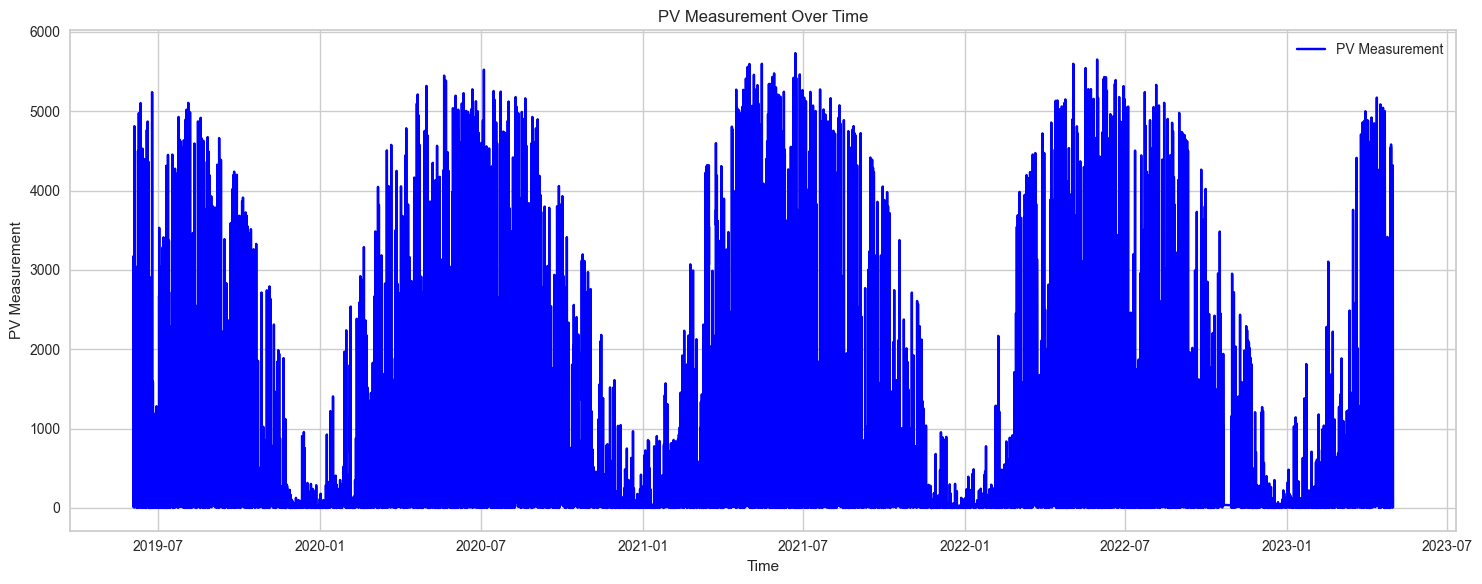

18036 X
18036 y
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training bec

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(18036, 163)"
4,Transformed data shape,"(18036, 175)"
5,Transformed train set shape,"(12625, 175)"
6,Transformed test set shape,"(5411, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,322.5502,262448.8821,512.2976,0.8591,0.7416,1.9253
1,307.8522,257304.0143,507.2514,0.8573,0.6848,1.2488
2,314.1401,274050.6068,523.4984,0.8484,0.7008,1.3020
3,315.1631,265832.4930,515.5895,0.8525,0.7025,1.2194
4,326.0725,278848.3678,528.0610,0.8509,0.7373,1.3746
5,328.1359,285307.3349,534.1417,0.8513,0.6813,1.0960
6,307.9342,262687.1709,512.5302,0.8591,0.7159,1.7645
7,330.5421,292607.0164,540.9316,0.8575,0.6717,1.2891
8,324.6372,284114.4672,533.0239,0.8462,0.6993,1.1531


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,331.2546,269248.9467,518.8920,0.8555,0.7566,2.0100
1,311.5240,258321.5528,508.2534,0.8568,0.6939,1.2823
2,318.9890,275043.6302,524.4460,0.8479,0.7120,1.3744
3,322.0138,274981.2936,524.3866,0.8474,0.7126,1.2689
4,332.9178,285634.1431,534.4475,0.8473,0.7449,1.4434
5,335.1828,291562.0551,539.9649,0.8481,0.6946,1.1482
6,314.8346,270489.2865,520.0858,0.8550,0.7284,1.7385
7,336.6300,300785.4766,548.4391,0.8535,0.6830,1.3378
8,330.4407,290917.7063,539.3679,0.8425,0.7203,1.2432


#############################################
Blended
#############################################
Finalized


float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


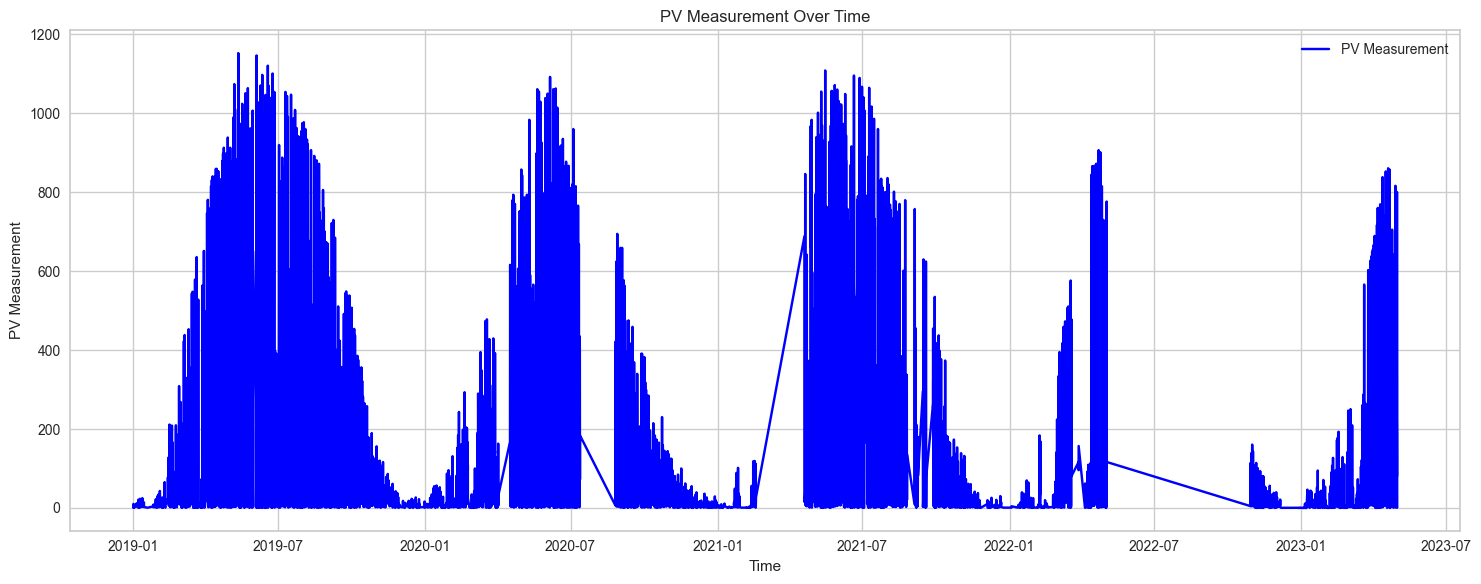

12274 X
12274 y
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training bec

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(12274, 163)"
4,Transformed data shape,"(12274, 174)"
5,Transformed train set shape,"(8591, 174)"
6,Transformed test set shape,"(3683, 174)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,51.9178,7447.9771,86.3017,0.8959,0.6819,1.8129
1,51.5814,7548.5588,86.8824,0.8905,0.6337,1.2816
2,49.7015,6711.6159,81.9245,0.8980,0.6385,1.4591
3,49.5032,6319.2474,79.4937,0.9049,0.6958,1.4835
4,51.5235,6969.7621,83.4851,0.8992,0.6686,1.4645
5,51.1790,7008.7456,83.7183,0.8927,0.7145,1.7208
6,52.7763,7425.1821,86.1695,0.8925,0.6956,1.4241
7,50.7113,7061.2163,84.0310,0.8996,0.7130,1.7759
8,57.6220,9977.6664,99.8883,0.8677,0.6921,15.2677


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.9064,7507.3365,86.6449,0.8951,0.6987,1.9311
1,52.9748,7925.3242,89.0243,0.8850,0.6534,1.3627
2,51.2427,7126.5982,84.4192,0.8917,0.6602,1.5655
3,51.1919,6704.0325,81.8782,0.8991,0.7149,1.5835
4,52.3342,7120.2621,84.3816,0.8970,0.6825,1.5634
5,52.7062,7376.3986,85.8860,0.8871,0.7253,1.7733
6,53.5093,7556.3564,86.9273,0.8906,0.7064,1.5027
7,51.9407,7222.2544,84.9838,0.8973,0.7285,1.9150
8,59.1449,10503.8690,102.4884,0.8608,0.7018,17.2101


#############################################
Blended
#############################################
Finalized


float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


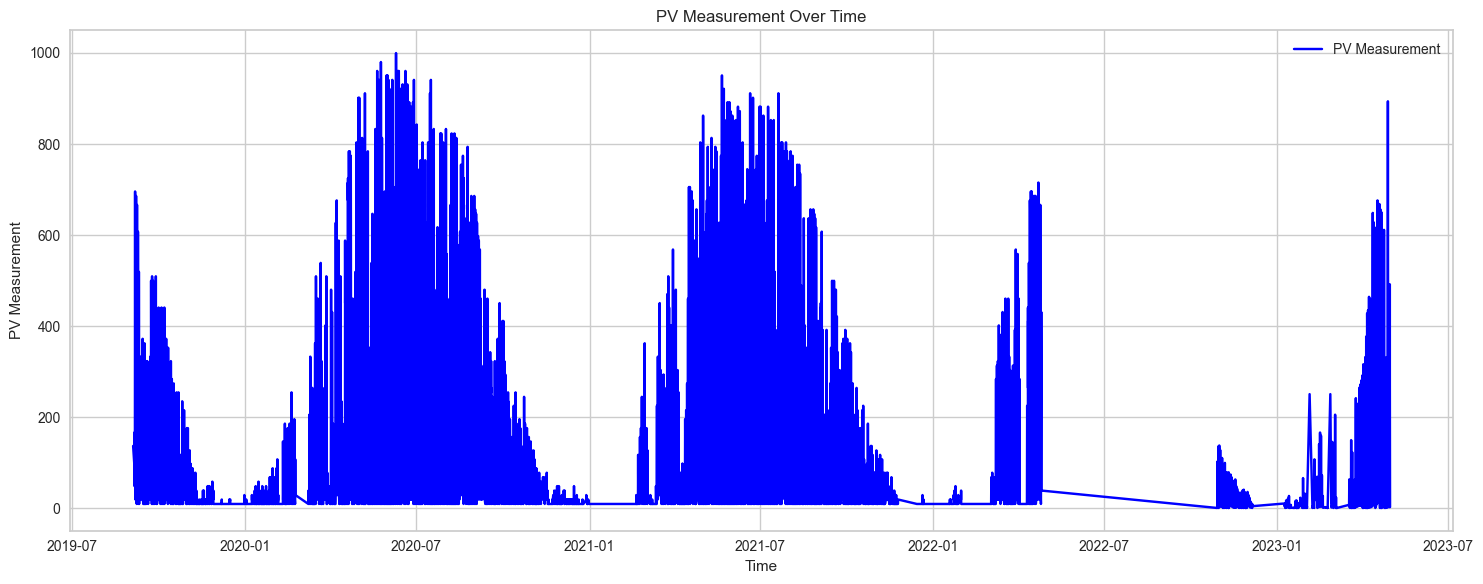

9676 X
9676 y
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training becau

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(9676, 163)"
4,Transformed data shape,"(9676, 175)"
5,Transformed train set shape,"(6773, 175)"
6,Transformed test set shape,"(2903, 175)"
7,Ordinal features,1
8,Numeric features,159
9,Categorical features,3


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are n

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,46.9723,6123.8296,78.2549,0.8653,0.5413,0.6912
1,43.6894,5152.4619,71.7807,0.8966,0.5204,0.5927
2,44.1512,5216.2188,72.2234,0.8946,0.4681,0.5321
3,51.3452,6794.0845,82.4262,0.8392,0.5838,0.8094
4,43.4614,4800.6356,69.2866,0.9057,0.4968,0.6170
5,46.0305,5532.5012,74.3808,0.8825,0.4912,0.5965
6,46.8174,5931.1746,77.0141,0.8595,0.4825,0.5201
7,46.2230,5840.1270,76.4207,0.8616,0.6309,1.1360
8,44.9797,5332.7321,73.0256,0.8869,0.5229,0.6986


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,47.5199,6199.0175,78.7338,0.8636,0.5623,0.7516
1,45.0476,5383.6602,73.3734,0.8919,0.5392,0.6493
2,45.1415,5390.5157,73.4201,0.8911,0.4768,0.5562
3,52.3751,6923.0553,83.2049,0.8361,0.5974,0.8468
4,45.5463,5159.7944,71.8317,0.8986,0.5191,0.6997
5,46.8376,5579.7508,74.6977,0.8815,0.5037,0.6190
6,48.5044,6208.6883,78.7952,0.8529,0.4988,0.5548
7,47.7834,6104.0415,78.1284,0.8554,0.6588,1.2915
8,45.3813,5332.9488,73.0270,0.8869,0.5418,0.7735


#############################################
Blended
#############################################
Finalized


float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


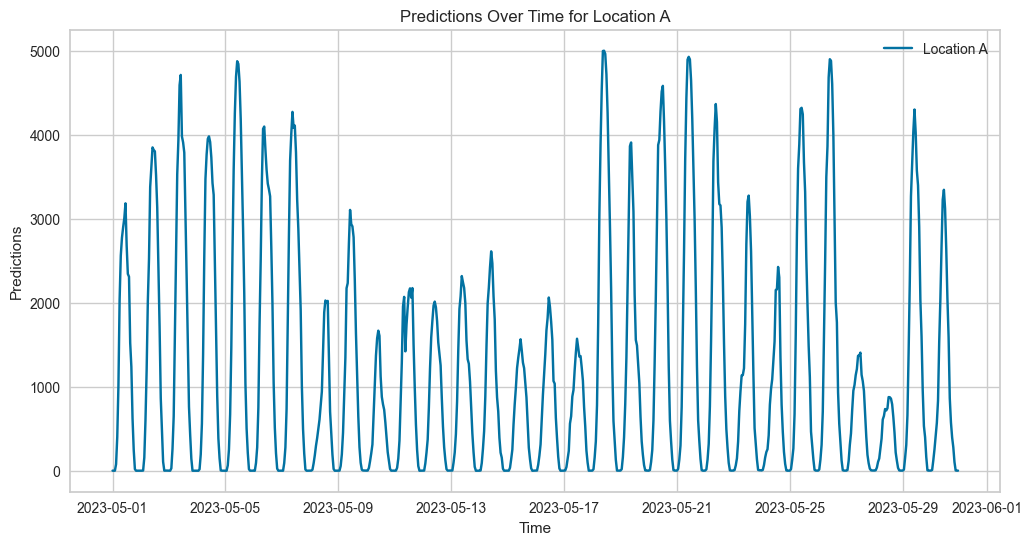

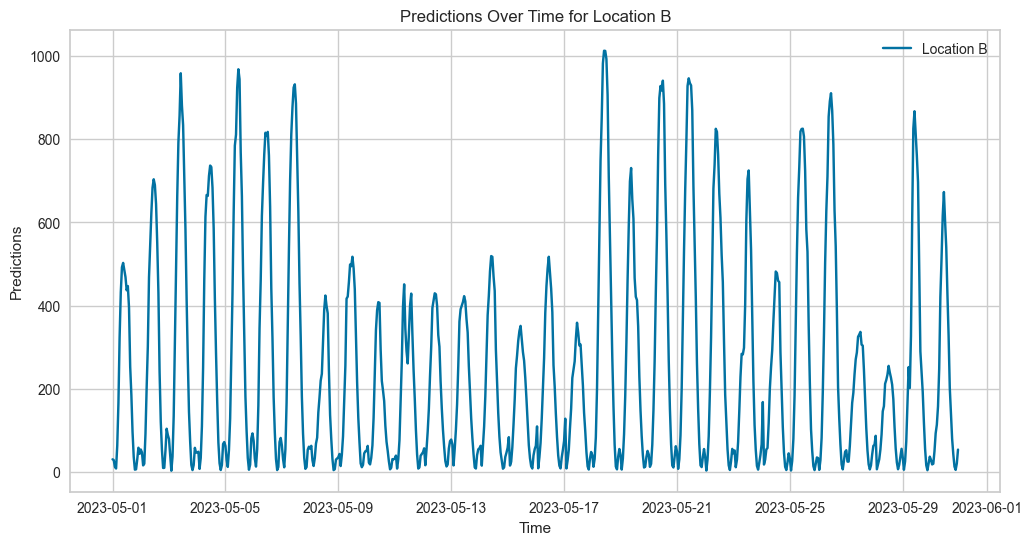

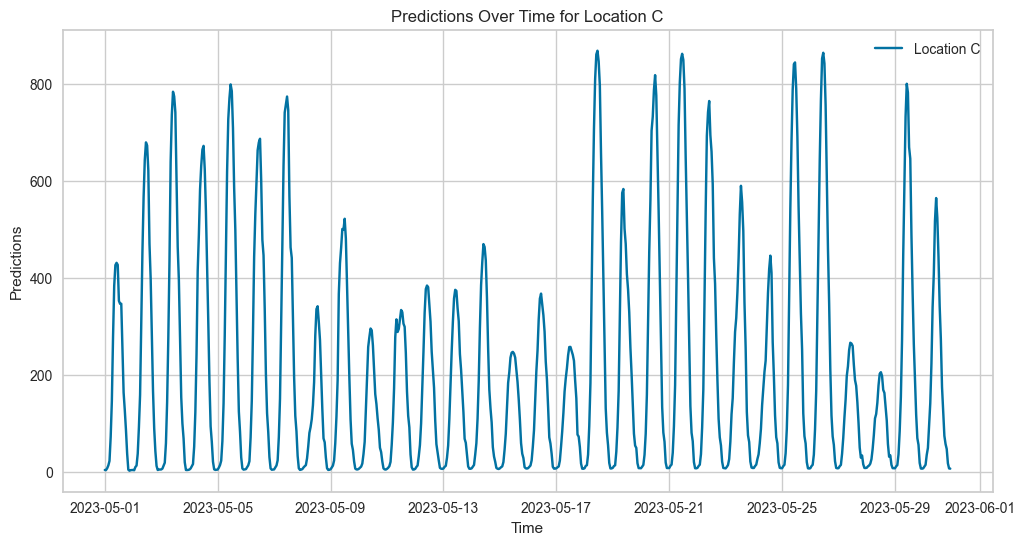

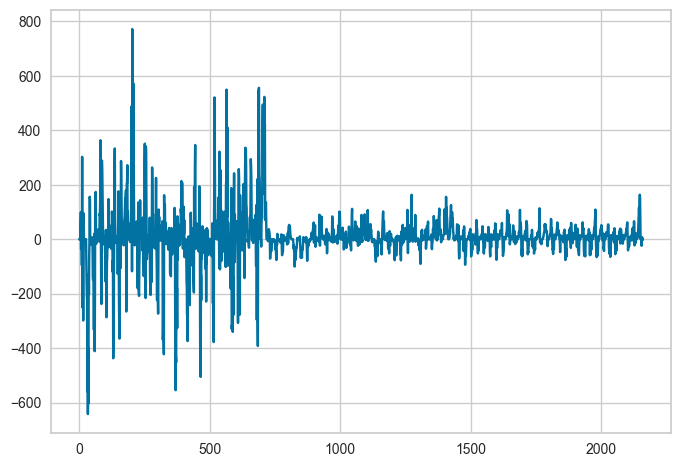

In [41]:
from pycaret.regression import *

sqrt = False

trainsize = 0.7

best_result = pd.read_csv("Predictions/multimodel_basic_cat_lgbm (1).csv")["prediction"]

for i in range(1):
    if i >= 10:
        trainsize = 0.9
    if i >= 10:
        sqrt = True
    locations = ['A', 'B', 'C']
    all_predictions = []
    final_df_list = [] 
    for loc in locations:
        # Load your data
        train = pd.read_parquet(f'Data/{loc}/train_targets.parquet').fillna(0)
        X_train_estimated = pd.read_parquet(f'Data/{loc}/X_train_estimated.parquet')
        X_train_observed = pd.read_parquet(f'Data/{loc}/X_train_observed.parquet')
        X_test_estimated = pd.read_parquet(f'Data/{loc}/X_test_estimated.parquet')

        #lage dag og måned feature der man aggregerer opp 
        # Preprocess data
        X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
        y_train = targets
        if X_train.empty or len(y_train) == 0:
            print(f"X_train or y_train is empty for location {loc}")

        # Ensure X and y have the same length
        print(len(X_train), 'X')
        print(len(y_train),'y')
        min_length = min(len(X_train), len(y_train))
        X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]


        data = X_train.copy()
        data.columns = data.columns.str.replace('[^\w\s]', '')

        X_test.columns = X_test.columns.str.replace('[^\w\s]', '')

        data['target'] = y_train['pv_measurement']
        if sqrt:
            data['target'] = np.sqrt(data['target'])
            
        if loc == "A":
            ignore_features = remove_features_A
        if loc == "B":
            ignore_features = remove_features_B
        if loc == "C":
            ignore_features = remove_features_C
            
        cat_fe = ['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated']
            
        # if len(list(set(ignore_features) & set(cat_fe))) != 0:
        #     for j in list(set(ignore_features) & set(cat_fe)):
        #         cat_fe.remove(j)
        # print(cat_fe)

        exp_reg = RegressionExperiment()
        exp_reg.setup(
            data=data,
            # train_size=trainsize,
            # ignore_features=ignore_features,
            target='target', 
            session_id=123,
            categorical_features=cat_fe,
            # html=False,
            experiment_name=f'exp_{loc}', 
            use_gpu=True,
            # verbose=False
        )
        
        # # Process the location data and get the final model
        # model_catboost = exp_reg.create_model('catboost',
        #                                     #   random_state=123
        #                                     )
        # print("#############################################")
        # print("Catboost Done")
        # model_lightgbm = exp_reg.create_model('lightgbm',
        #                                     #   random_state=123
        #                                       )
        # print("#############################################")
        # print("LGBM Done")
        
        print("et")
        model_et = exp_reg.create_model('et')
        bag_et = exp_reg.ensemble_model(model_et, method='Bagging')
        #blend_models = blend_models(estimator_list=[model_catboost, model_lightgbm, model_xtra_trees], method='soft')
        # blended_models = exp_reg.blend_models([model_catboost, model_lightgbm])
        print("#############################################")
        print("Blended")
        # Finalize the model
        #blended_models = exp_reg.tune_model(blended_models)
        blended_models = exp_reg.finalize_model(bag_et)
        print("#############################################")
        print("Finalized")
        # Predict on new data
        predictions = exp_reg.predict_model(blended_models, data=X_test)
            #print(predictions.columns)
            # Assuming 'predictions' is the output from predict_model
        final_predictions = (predictions['prediction_label'])
        if sqrt:
            final_predictions = final_predictions**2
        print(final_predictions.dtypes)
        print(is_day_feature.dtypes)
        # Multiply final predictions with the 'is_day:idx' values
        
        adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
        adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
        # Now, 'adjusted_final_predictions' contains the adjusted target values.

            # Store predictions
        all_predictions.append(adjusted_final_predictions)  

            # Prepare dataframe for visualization
        num_predictions = len(predictions)
        timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

        df = pd.DataFrame({
                'time': timestamps,
                'prediction': predictions['prediction_label'],
                'location': loc
            })

        final_df_list.append(df)


    # Concatenate all the individual data frames and prepare for plotting
    final_df = pd.concat(final_df_list, ignore_index=True)
    final_df['time'] = pd.to_datetime(final_df['time'])
    final_df.sort_values('time', inplace=True)

    # Visualization
    for loc in locations:
        # Filter data for each location
        temp_df = final_df[final_df['location'] == loc]
        
        plt.figure(figsize=(12, 6))  # Create a new figure for each location
        plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
        plt.xlabel('Time')
        plt.ylabel('Predictions')
        plt.title(f'Predictions Over Time for Location {loc}')
        plt.legend()
        plt.show()

    # If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
    final_df_save = final_df.copy()
    final_df_save = final_df_save.drop(columns=['time', 'location'])
    
    def save_predictions(all_predictions, title):
        final_predictions = np.concatenate(all_predictions)
        df = pd.DataFrame(final_predictions, columns=['prediction'])
        df['id'] = df.index
        df = df[['id', 'prediction']]
        # df.to_csv(f"GPU_simple_cat_lgbm_seed_123/{title}", index=False)
        df.to_csv(f"{title}", index=False)

    # def plot_from_csv(title):
    #     plt.figure(figsize=(12, 6))
    #     df = pd.read_csv(title)
    #     plt.plot(df['prediction'], label=title)
    #     plt.xlabel('Time')
    #     plt.ylabel('Predictions')
    #     plt.title('Predictions Over Time')
    #     plt.legend()
    #     plt.show()


    title = f'multimodel_basic_et_seed_123_run_{i+1}_bagged.csv'
    if sqrt:
        title = f'multimodel_basic_cat_lgbm_seed_123_run_{i+1}_blend_06_04_sqrt.csv'
    if trainsize == 0.8:
        title = f"multimodel_basic_cat_lgbm_seed_123_run_{i+1}_trainsize_80.csv"
    if trainsize == 0.9:
        title = f"multimodel_basic_cat_lgbm_seed_123_run_{i+1-10}_trainsize_90.csv"
    save_predictions(all_predictions, title)
    
    plt.plot(np.concatenate(all_predictions) - best_result)
    # plot_from_csv(title)

In [96]:
i=0

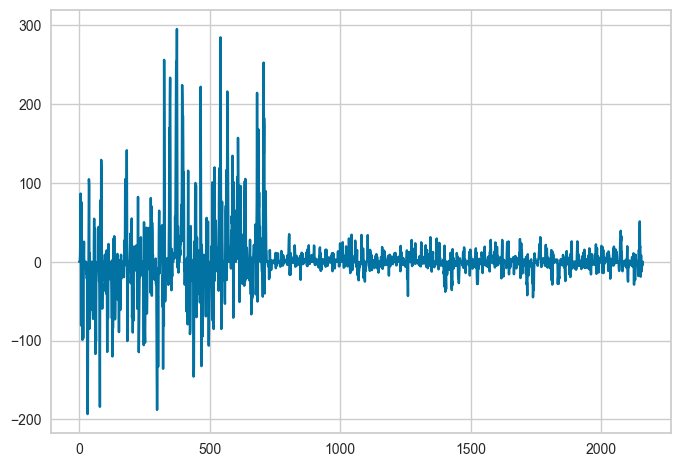

In [97]:
title = f'multimodel_basic_cat_lgbm_seed_123_run_{i+1}_remove_useless_features_0_point_5_upper_limit.csv'
save_predictions(all_predictions, title)
plt.plot(np.concatenate(all_predictions) - best_result)

In [95]:
print(i)

is_estimated


In [94]:
i+1

TypeError: can only concatenate str (not "int") to str

In [93]:
f'multimodel_basic_cat_lgbm_seed_123_remove_useless_features_0_point_5_upper_limit_run_{i+1}.csv'

TypeError: can only concatenate str (not "int") to str

In [91]:
title 

NameError: name 'title' is not defined

In [ ]:
plt.plot(final_df['time'], final_df['prediction'], label='Prediction')

In [ ]:
best_result = pd.read_csv("Predictions/multimodel_basic_cat_lgbm (1).csv")["prediction"]

In [ ]:
plt.plot(pd.read_csv("GPU_simple_cat_lgbm_seed_123/multimodel_basic_cat_lgbm_seed_123_run{i+1}.csv")["prediction"] - pd.read_csv("GPU_simple_cat_lgbm_seed_123/multimodel_basic_cat_lgbm_seed_123_run_1.csv")["prediction"])

# Export

In [ ]:
def save_predictions(all_predictions, title):
    final_predictions = np.concatenate(all_predictions)
    df = pd.DataFrame(final_predictions, columns=['prediction'])
    df['id'] = df.index
    df = df[['id', 'prediction']]
    df.to_csv(title, index=False)

def plot_from_csv(title):
    plt.figure(figsize=(12, 6))
    df = pd.read_csv(title)
    plt.plot(df['prediction'], label=title)
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title('Predictions Over Time')
    plt.legend()
    plt.show()
    

title = 'multimodel_basic_cat_lgbm.csv'
save_predictions(all_predictions, title)
plot_from_csv(title)


In [ ]:
df1 = pd.read_csv('pycaret_catboost_IMPORTANT.csv')
df2 = pd.read_csv('pycaret_advanced_rolling357.csv')
df3 = pd.read_csv('multimodel_basic_cat_lgbm.csv')

df1['prediction'] = df1['prediction'].astype(float)
df2['prediction'] = df2['prediction'].astype(float)
df3['prediction'] = df3['prediction'].astype(float)

# Plot different between df1 and df3 
plt.figure(figsize=(24, 12))
plt.plot(df1['prediction'] - df3['prediction'], label='df1 - df3', c = 'blue')
plt.plot(df2['prediction'] - df3['prediction'], label='df2 - df3', c = 'red')   
plt.plot(df1['prediction'] - df2['prediction'], label='df1 - df2', c = 'green')
plt.show()

In [ ]:
# read from pycaret_catboost_IMPORTANT.csv and pycaret_gbm_include_zero.csv and plot the difference
df1 = pd.read_csv('pycaret_catboost_IMPORTANT.csv')
df2 = pd.read_csv('pycaret_advanced_rolling357.csv')
df1['prediction'] = df1['prediction'].astype(float)
df2['prediction'] = df2['prediction'].astype(float)

df_diff = df1['prediction'] - df2['prediction']

plt.figure(figsize=(12, 6))
plt.plot(df_diff, label='Difference')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Difference Between Predictions Over Time')
plt.legend()
plt.show()


In [ ]:
# plot df1 and df2
plt.figure(figsize=(12, 6))
plt.plot(df1['prediction'], label='df1')
plt.plot(df2['prediction'], label='df2')
plt.xlabel('Time')
plt.ylabel('Predictions')
plt.title('Predictions Over Time')
plt.legend()
plt.show()

In [ ]:
df1 = pd.read_csv('pycaret_catboost_IMPORTANT.csv')
df2 = pd.read_csv('pycaret_advanced_rolling357.csv')
df1['prediction'] = df1['prediction'].astype(float)
df2['prediction'] = df2['prediction'].astype(float)

# take the average of the two predictions
df_avg = (df1['prediction'] + df2['prediction']) / 2

plt.figure(figsize=(12, 6))
plt.plot(df_avg, label='Average')
plt.show()

In [ ]:
# save the average predictions
df = pd.DataFrame(df_avg, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('pycaret_catboost_gbm_average.csv', index=False)

In [ ]:
df_av = pd.read_csv('pycaret_catboost_gbm_average.csv')

# plot difference between df_av and df3
plt.figure(figsize=(24, 12))
plt.plot(df_av['prediction'] - df3['prediction'], label='df_av - df3')
plt.show()

#calculate MAE of df_av and df3
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(df_av['prediction'], df3['prediction'])
print(score)